In [10]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [11]:
# Define the path to the dataset
base_path = '/Users/admin/AIEngineer/DeepFakeProject/Dataset/Faceplus2'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [3]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,596_609_frame_0019.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,596,19,fake,0
1,746_571_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,746,8,fake,0
2,514_443_frame_0028.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,514,28,fake,0
3,642_635_frame_0006.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,642,6,fake,0
4,937_888_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,937,9,fake,0
...,...,...,...,...,...,...
59803,727_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,727,9,real,1
59804,832_frame_0026.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,832,26,real,1
59805,059_frame_0005.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,59,5,real,1
59806,572_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,572,8,real,1


In [4]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
labels 


{'596_fake': 0,
 '746_fake': 0,
 '514_fake': 0,
 '642_fake': 0,
 '937_fake': 0,
 '0_fake': 0,
 '241_fake': 0,
 '174_fake': 0,
 '308_fake': 0,
 '348_fake': 0,
 '793_fake': 0,
 '961_fake': 0,
 '991_fake': 0,
 '653_fake': 0,
 '341_fake': 0,
 '304_fake': 0,
 '687_fake': 0,
 '719_fake': 0,
 '90_fake': 0,
 '38_fake': 0,
 '827_fake': 0,
 '605_fake': 0,
 '454_fake': 0,
 '244_fake': 0,
 '418_fake': 0,
 '4_fake': 0,
 '538_fake': 0,
 '79_fake': 0,
 '128_fake': 0,
 '146_fake': 0,
 '766_fake': 0,
 '155_fake': 0,
 '579_fake': 0,
 '581_fake': 0,
 '692_fake': 0,
 '580_fake': 0,
 '898_fake': 0,
 '641_fake': 0,
 '171_fake': 0,
 '737_fake': 0,
 '832_fake': 0,
 '337_fake': 0,
 '510_fake': 0,
 '879_fake': 0,
 '408_fake': 0,
 '143_fake': 0,
 '487_fake': 0,
 '865_fake': 0,
 '73_fake': 0,
 '682_fake': 0,
 '287_fake': 0,
 '743_fake': 0,
 '922_fake': 0,
 '407_fake': 0,
 '133_fake': 0,
 '850_fake': 0,
 '234_fake': 0,
 '478_fake': 0,
 '325_fake': 0,
 '840_fake': 0,
 '886_fake': 0,
 '611_fake': 0,
 '125_fake': 0,


In [7]:
!pip install opencv-python

In [7]:
# Chuẩn bị dữ liệu
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

# Cấu hình
img_size = (224, 224)
batch_size = 16
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Custom data generator để nạp chuỗi ảnh từ video_dict
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            frames = video_dict[key][:self.sequence_len]
            imgs = []
            for path in frames:
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))  # padding
            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# Hàm xây dựng mô hình
def build_model(sequence_len, img_size):
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')

    # Freeze toàn bộ backbone để giảm overfit
    base_cnn.trainable = False

    # CNN feature extractor
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    # Sequence input
    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)

    # LSTM đơn giản hơn
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Không dùng nhiều Dense, chỉ một đầu ra
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# K-Fold huấn luyện
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen   = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen  = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=SGD(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen,
                        epochs=epochs, callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)

    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

# Tổng kết kết quả
print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


2025-06-27 08:53:14.658544: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-27 08:53:14.658694: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-27 08:53:14.658705: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-27 08:53:14.658751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-27 08:53:14.658777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-06-27 08:53:17.821650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


90/90 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5507
Epoch 1: val_accuracy improved from -inf to 0.58125, saving model to best_model_fold1.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 63s 655ms/step - loss: 0.7005 - accuracy: 0.5507 - val_loss: 0.6829 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.5618
Epoch 2: val_accuracy improved from 0.58125 to 0.58750, saving model to best_model_fold1.h5
90/90 [==============================] - 60s 664ms/step - loss: 0.6969 - accuracy: 0.5618 - val_loss: 0.6814 - val_accuracy: 0.5875 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5479
Epoch 3: val_accuracy did not improve from 0.58750
90/90 [==============================] - 54s 588ms/step - loss: 0.6962 - accuracy: 0.5479 - val_loss: 0.6798 - val_accuracy: 0.5875 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.5611
Epoch 4: val_accuracy did not improve from 0.58750
90/90 [==============================] - 54s 592ms/step - loss: 0.6975 - accu

/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 51s 542ms/step - loss: 0.7393 - accuracy: 0.4618 - val_loss: 0.7073 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.4819
Epoch 2: val_accuracy did not improve from 0.47500
90/90 [==============================] - 54s 593ms/step - loss: 0.7337 - accuracy: 0.4819 - val_loss: 0.7056 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.4889
Epoch 3: val_accuracy did not improve from 0.47500
90/90 [==============================] - 50s 554ms/step - loss: 0.7320 - accuracy: 0.4889 - val_loss: 0.7039 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.4903
Epoch 4: val_accuracy did not improve from 0.47500
90/90 [==============================] - 51s 558ms/step - loss: 0.7290 - accuracy: 0.4903 - val_loss: 0.7025 - val_acc

/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 54s 584ms/step - loss: 0.7405 - accuracy: 0.4924 - val_loss: 0.7003 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.4799
Epoch 2: val_accuracy did not improve from 0.53750
90/90 [==============================] - 53s 587ms/step - loss: 0.7343 - accuracy: 0.4799 - val_loss: 0.6980 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7246 - accuracy: 0.5104
Epoch 3: val_accuracy improved from 0.53750 to 0.55000, saving model to best_model_fold3.h5
90/90 [==============================] - 56s 614ms/step - loss: 0.7246 - accuracy: 0.5104 - val_loss: 0.6962 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.5306
Epoch 4: val_accuracy improved from 0.55000 to 0.55625, saving model to best_model_fold3.h5
90/90 [=============================

/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 55s 586ms/step - loss: 0.7218 - accuracy: 0.5000 - val_loss: 0.7142 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.5014
Epoch 2: val_accuracy improved from 0.45000 to 0.45625, saving model to best_model_fold4.h5
90/90 [==============================] - 53s 589ms/step - loss: 0.7174 - accuracy: 0.5014 - val_loss: 0.7125 - val_accuracy: 0.4563 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.4979
Epoch 3: val_accuracy did not improve from 0.45625
90/90 [==============================] - 59s 653ms/step - loss: 0.7116 - accuracy: 0.4979 - val_loss: 0.7109 - val_accuracy: 0.4563 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.5146
Epoch 4: val_accuracy improved from 0.45625 to 0.46250, saving model to best_model_fold4.h5
90/90 [=============================

/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 61s 648ms/step - loss: 0.7407 - accuracy: 0.5153 - val_loss: 0.6887 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.5271
Epoch 2: val_accuracy improved from 0.57500 to 0.60625, saving model to best_model_fold5.h5
90/90 [==============================] - 50s 553ms/step - loss: 0.7303 - accuracy: 0.5271 - val_loss: 0.6821 - val_accuracy: 0.6062 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.5201
Epoch 3: val_accuracy did not improve from 0.60625
90/90 [==============================] - 56s 617ms/step - loss: 0.7158 - accuracy: 0.5201 - val_loss: 0.6780 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.5208
Epoch 4: val_accuracy did not improve from 0.60625
90/90 [==============================] - 57s 629ms/step - loss: 0.7138 - accu

In [8]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.516500
precision    0.516362
recall       0.592000
f1           0.548452
auc          0.529195
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.5750,0.569444,0.615,0.591346,0.580850
1,2,0.4775,0.481013,0.570,0.521739,0.439325
2,3,0.5075,0.507614,0.500,0.503778,0.517950
3,4,0.5275,0.527094,0.535,0.531017,0.560725
4,5,0.4950,0.496644,0.740,0.594378,0.547125


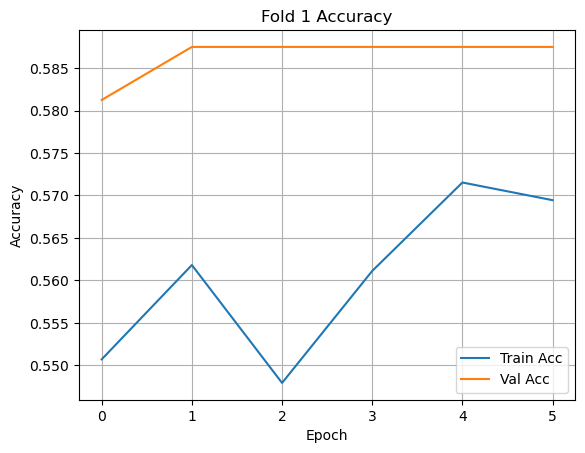

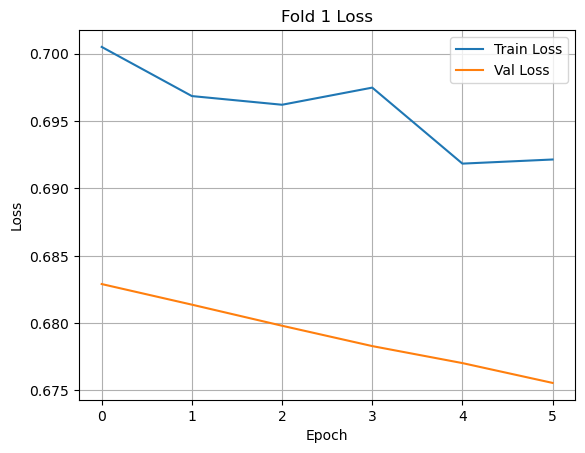

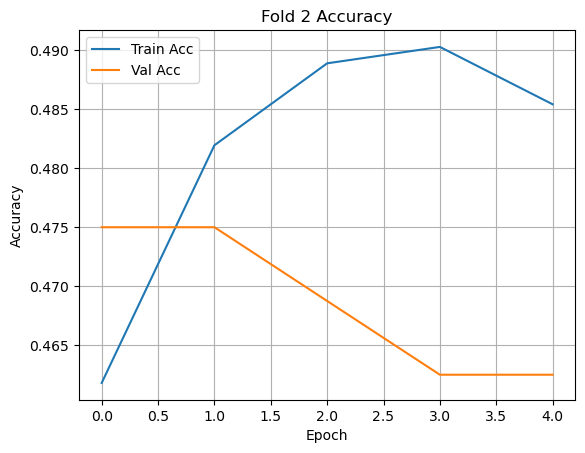

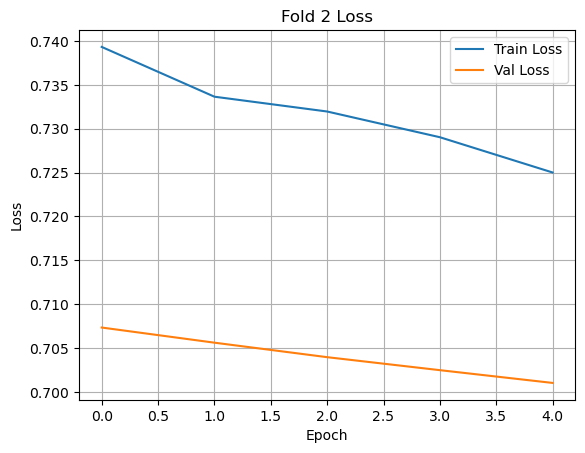

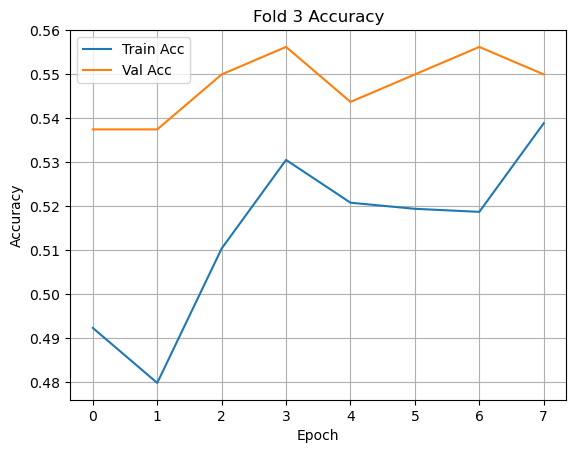

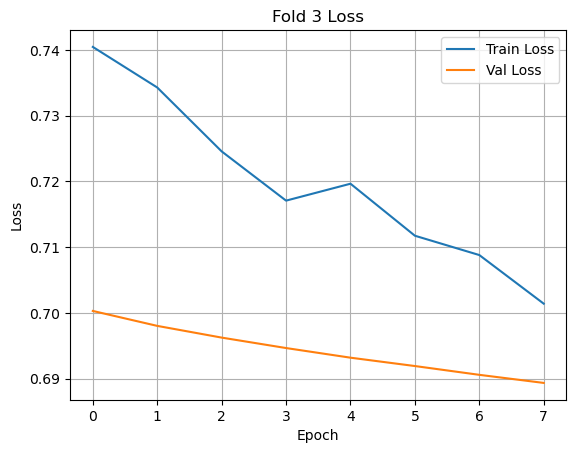

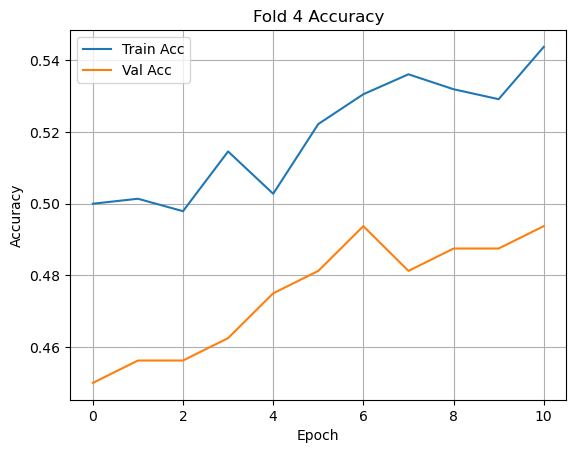

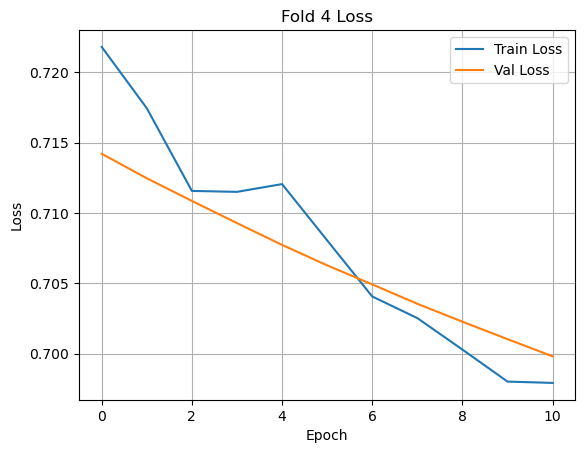

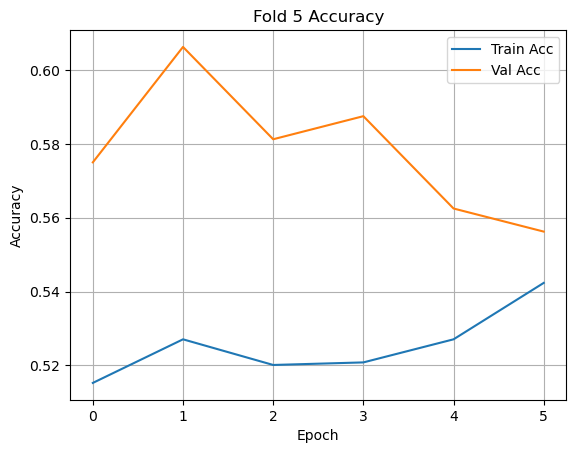

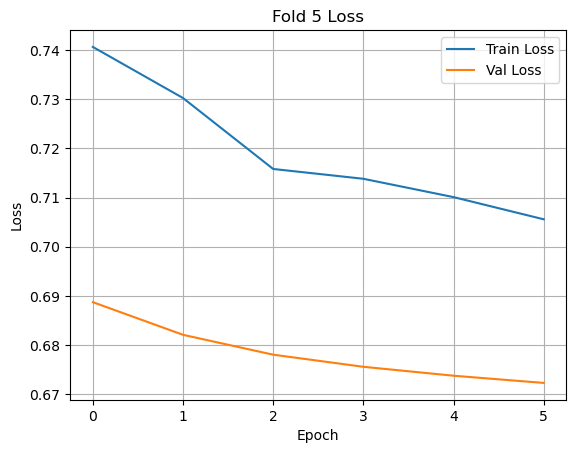

In [9]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_faceplus_sgd_final.h5")


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
